# Convert Sigmet files into Zarr

## Imports

In [1]:
import xradar as xd
import fsspec
import datatree
import pyproj
from datetime import datetime
from wradlib.georef import epsg_to_osr, georeference
from cartopy import crs as ccrs
from sigmet2zarr.utils import create_query, check_if_exist, make_dir
from sigmet2zarr.task2zarr import raw2zarr

Now let's convert some sigmet files hosted in [IDEAM](https://registry.opendata.aws/ideam-radares/) AWS bucket.

In [2]:
# radar
radar_name = "Carimagua"
zarr_version = 2

# Store path to save radar datatree in Zarr format
zarr_store = f'../zarr/{radar_name}.zarr'
make_dir(zarr_store)

# Lest define some dates to convert
year, months, days = 2022, range(8, 9), range(9, 10)

# data needs to be converted sequentially since zarr is using consolidated metadata
for month in months:                                                                                                                                                                                                                                                                                                              
    for day in days:
        # datetime object
        date_query = datetime(year=year, month=month, day=day)
        
        # Create AWS bucket string query
        query = create_query(date=date_query, radar_site=radar_name)
        str_bucket = 's3://s3-radaresideam/'

        # Using Fsspec to create a virtual connection with the S3 Bucket
        fs = fsspec.filesystem("s3", anon=True)

        # Glob the files within the bucket
        radar_files = sorted(fs.glob(f"{str_bucket}{query}*"))

        # loop through each file that will be converted and saved in zarr format
        if radar_files:
            for i in radar_files[:10]:
                # in order not to reprocess file we can check if the file was already processed
                exist = check_if_exist(i)
                if not exist:
                    # conver each file into zarr
                    raw2zarr(i, store=zarr_store, mode='a', consolidated=True, 
                           append_dim='vcp_time', zarr_version=zarr_version,)

## Read the radar datatree store in Zarr format

In [3]:
dt_radar = datatree.open_datatree(zarr_store, engine='zarr')

In [4]:
list(dt_radar.children)

['sweep_0', 'sweep_5', 'sweep_6', 'sweep_7', 'sweep_8', 'sweep_9']

We can now access each sweep by using a key-value method. Let's check the lowest elevation angle

In [5]:
ds_05 = dt_radar['sweep_0'].ds
display(ds_05)

<xarray.DatasetView>
Dimensions:            (vcp_time: 3, azimuth: 720, range: 994)
Coordinates:
    altitude           float64 ...
  * azimuth            (azimuth) float32 0.25 0.75 1.25 ... 358.8 359.2 359.8
    crs_wkt            int64 ...
    elevation          (azimuth) float32 ...
    latitude           float64 ...
    longitude          float64 ...
  * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
    time               (azimuth) datetime64[ns] ...
  * vcp_time           (vcp_time) datetime64[ns] 2022-08-09T00:01:17.76500006...
    x                  (azimuth, range) float64 ...
    y                  (azimuth, range) float64 ...
    z                  (azimuth, range) float64 ...
Data variables: (12/17)
    DBTH               (vcp_time, azimuth, range) float32 ...
    DBZH               (vcp_time, azimuth, range) float32 ...
    DB_DBTE8           (vcp_time, azimuth, range) float32 ...
    DB_DBZE8           (vcp_time, azimuth, range) float32 ...
    DB_HCLASS          (vcp_time, azimuth, range) int16 ...
    KDP                (vcp_time, azimuth, range) float32 ...
    ...                 ...
    ZDR                (vcp_time, azimuth, range) float32 ...
    follow_mode        (vcp_time) <U7 ...
    prt_mode           (vcp_time) <U7 ...
    sweep_fixed_angle  (vcp_time) float64 ...
    sweep_mode         (vcp_time) <U20 ...
    sweep_number       (vcp_time) int64 ...

Now we can create look at the horizontal radar reflectivity and create a plot using xarray plot buildin function

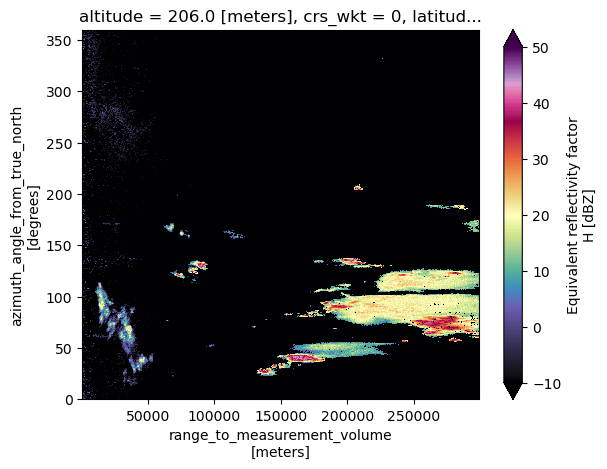

In [6]:
ds_05.isel(vcp_time=0).DBZH.plot(cmap='ChaseSpectral', vmin=-10, vmax=50)

Before creating a radar plot we need to georeference the dataset. This can be done using `xradar.georeference` module

In [12]:
ds_05 = xd.georeference.get_x_y_z(ds_05)
display(ds_05)

<xarray.Dataset>
Dimensions:            (vcp_time: 3, azimuth: 720, range: 994)
Coordinates:
    altitude           float64 206.0
  * azimuth            (azimuth) float32 0.25 0.75 1.25 ... 358.8 359.2 359.8
    crs_wkt            int64 0
    elevation          (azimuth) float32 0.4999 0.4999 0.4999 ... 0.4999 0.4999
    latitude           float64 4.564
    longitude          float64 ...
  * range              (range) float32 1e+03 1.3e+03 ... 2.986e+05 2.989e+05
    time               (azimuth) datetime64[ns] ...
  * vcp_time           (vcp_time) datetime64[ns] 2022-08-09T00:01:17.76500006...
    x                  (azimuth, range) float32 4.363 5.672 ... -1.303e+03
    y                  (azimuth, range) float32 999.9 1.3e+03 ... 2.987e+05
    z                  (azimuth, range) float32 214.0 217.0 ... 8.063e+03
Data variables: (12/17)
    DBTH               (vcp_time, azimuth, range) float32 ...
    DBZH               (vcp_time, azimuth, range) float32 ...
    DB_DBTE8           (vcp_time, azimuth, range) float32 ...
    DB_DBZE8           (vcp_time, azimuth, range) float32 ...
    DB_HCLASS          (vcp_time, azimuth, range) int16 ...
    KDP                (vcp_time, azimuth, range) float32 ...
    ...                 ...
    ZDR                (vcp_time, azimuth, range) float32 ...
    follow_mode        (vcp_time) <U7 ...
    prt_mode           (vcp_time) <U7 ...
    sweep_fixed_angle  (vcp_time) float64 ...
    sweep_mode         (vcp_time) <U20 ...
    sweep_number       (vcp_time) int64 ...

Now we can create a radil plot

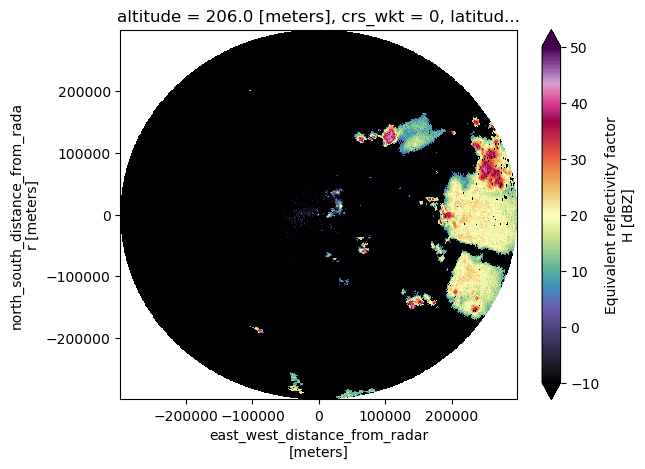

In [13]:
ds_05.isel(vcp_time=0).DBZH.plot(x="x", y="y", cmap="ChaseSpectral", vmin=-10, vmax=50)